## Final Evaluations

Check on test dataset partition performance metrics F1-score, Precision, Recall, Accuracy, AUC-ROC 
FPR parity 
Plot confusion matrices side-by-side 
Analyze intersections: Evaluate metrics across intersections of sensitive attributes (e.g., gender × race) 
Check bias amplification: Compare the distribution of predictions against the training data distribution to detect potential amplification of existing biases 
Plot fairness metrics against performance metrics to visualize tradeoffs

In [37]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns
from fairlearn.metrics import MetricFrame, false_positive_rate

# === Load data and pipeline ===
df = pd.read_csv("../data/cox-violent-preprocessed.csv")
pipeline = joblib.load("../models/pipeline_preprocessing.pkl")

X_raw = df.drop("is_recid", axis=1).copy()
y = df["is_recid"].copy()
X_transformed = pipeline.transform(X_raw)

# Select modeling features
selected_features = [
    "age", "sex", "juv_misd_count", "juv_fel_count",
    "priors_count", "c_charge_degree", "c_charge_desc"
]
feature_indices = [X_raw.columns.get_loc(f) for f in selected_features]
X_selected = X_transformed[:, feature_indices]

# Train/Val/Test Split
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_selected, y, test_size=0.15, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.176, stratify=y_trainval, random_state=42
)

# Sensitive attributes
X_test_df = X_raw.iloc[y_test.index].copy()
sex_test = X_test_df["sex"].values
race_test = X_test_df["race"].values
intersection_test = [f"{s} × {r}" for s, r in zip(sex_test, race_test)]
y_train_dist = y_train.value_counts(normalize=True)

# === Load finetuned models ===
models = {
    "Logistic Regression": joblib.load("../models/tuned/logistic_regression_finetuned.pkl"),
    "AdaBoost": joblib.load("../models/tuned/adaboost_finetuned.pkl"),
    "Neural Network": joblib.load("../models/tuned/neural_network_finetuned.pkl"),
}

# === Load debiased final models ===
debiased_path = "../models/debiased_final"
model_file_map = {
    "Logistic Regression": "logistic_regression_debiased_final.pkl",
    "AdaBoost": "adaboost_debiased_final.pkl",
    "Neural Network": "neural_network_debiased_final.pkl"
}

for model_name, filename in model_file_map.items():
    path = os.path.join(debiased_path, filename)
    if os.path.exists(path):
        loaded = joblib.load(path)
        if isinstance(loaded, dict) and "model" in loaded and "thresholds" in loaded:
            models[model_name + " Debiased Final"] = loaded
            print(f"[INFO] Loaded debiased model: {model_name} Debiased Final")
            print(f"[DEBUG] Thresholds: {loaded['thresholds']}")

# === Compare logistic and neural network outputs ===
logreg = models.get("Logistic Regression Debiased Final") or models["Logistic Regression"]
nn = models.get("Neural Network Debiased Final") or models["Neural Network"]

logreg_model = logreg["model"] if isinstance(logreg, dict) else logreg
logreg_thresh = logreg["thresholds"] if isinstance(logreg, dict) else {"African-American": 0.5, "Caucasian": 0.5}

nn_model = nn["model"] if isinstance(nn, dict) else nn
nn_thresh = nn["thresholds"] if isinstance(nn, dict) else {"African-American": 0.5, "Caucasian": 0.5}

logreg_proba = logreg_model.predict_proba(X_test)[:, 1]
nn_proba = nn_model.predict_proba(X_test)[:, 1]

print("\n=== Model Probability Differences ===")
print("Max absolute diff:", np.max(np.abs(logreg_proba - nn_proba)))
print("Mean absolute diff:", np.mean(np.abs(logreg_proba - nn_proba)))

logreg_preds = np.array([
    1 if p >= logreg_thresh.get(r, 0.5) else 0
    for p, r in zip(logreg_proba, race_test)
])
nn_preds = np.array([
    1 if p >= nn_thresh.get(r, 0.5) else 0
    for p, r in zip(nn_proba, race_test)
])

print("\n=== Prediction Differences ===")
print("Predictions equal:", np.array_equal(logreg_preds, nn_preds))
print("Different prediction count:", np.sum(logreg_preds != nn_preds))

# === Evaluate all models ===
results = []
conf_matrices = {}

for model_name, model_obj in models.items():
    print(f"\n=== Evaluating: {model_name} ===")

    if isinstance(model_obj, dict):
        model = model_obj["model"]
        thresholds = model_obj["thresholds"]

        if "Male" in thresholds:
            group_attr = sex_test
        elif "Caucasian" in thresholds:
            group_attr = race_test
        else:
            group_attr = sex_test  # fallback

        probas = model.predict_proba(X_test)[:, 1]
        preds = [
            1 if p >= thresholds.get(g, 0.5) else 0
            for p, g in zip(probas, group_attr)
        ]
    else:
        model = model_obj
        probas = model.predict_proba(X_test)[:, 1]
        preds = (probas >= 0.5).astype(int)

    acc = accuracy_score(y_test, preds)
    prec = precision_score(y_test, preds, zero_division=0)
    rec = recall_score(y_test, preds)
    f1 = f1_score(y_test, preds)
    auc = roc_auc_score(y_test, probas)
    cm = confusion_matrix(y_test, preds)
    conf_matrices[model_name] = cm

    fpr_sex = MetricFrame(metrics=false_positive_rate, y_true=y_test, y_pred=preds, sensitive_features=sex_test)
    fpr_gap_sex = abs(fpr_sex.by_group.max() - fpr_sex.by_group.min())

    fpr_race = MetricFrame(metrics=false_positive_rate, y_true=y_test, y_pred=preds, sensitive_features=race_test)
    fpr_gap_race = abs(fpr_race.by_group.max() - fpr_race.by_group.min())

    pred_dist = pd.Series(preds).value_counts(normalize=True)
    amplification = abs(pred_dist.get(1, 0) - y_train_dist.get(1, 0))

    # intersection_frame = MetricFrame(
    #     metrics={"accuracy": accuracy_score, "f1": f1_score},
    #     y_true=y_test, y_pred=preds, sensitive_features=intersection_test    )

    results.append({
        "Model": model_name,
        "Accuracy": round(acc, 3),
        "Precision": round(prec, 3),
        "Recall": round(rec, 3),
        "F1 Score": round(f1, 3),
        "AUC-ROC": round(auc, 3),
        "FPR Gap (sex)": round(fpr_gap_sex, 3),
        "FPR Gap (race)": round(fpr_gap_race, 3),
        "Bias Amplification": round(amplification, 3),
        #"Intersectional F1 Range": round(intersection_frame.by_group["f1"].max() - intersection_frame.by_group["f1"].min(), 3)
    })

# Save and display evaluation
df_eval = pd.DataFrame(results).sort_values(by="F1 Score", ascending=False)
os.makedirs("../reports/03_evaluation", exist_ok=True)
df_eval.to_csv("../reports/03_evaluation/final_model_evaluation.csv", index=False)
df_eval.head()




[INFO] Loaded debiased model: Logistic Regression Debiased Final
[DEBUG] Thresholds: {'Caucasian': np.float64(0.9), 'African-American': np.float64(0.9)}
[INFO] Loaded debiased model: Neural Network Debiased Final
[DEBUG] Thresholds: {'Caucasian': np.float64(0.9), 'African-American': np.float64(0.9)}

=== Model Probability Differences ===
Max absolute diff: 0.28497984041116575
Mean absolute diff: 0.05571924798888415

=== Prediction Differences ===
Predictions equal: False
Different prediction count: 34

=== Evaluating: Logistic Regression ===

=== Evaluating: AdaBoost ===

=== Evaluating: Neural Network ===

=== Evaluating: Logistic Regression Debiased Final ===

=== Evaluating: Neural Network Debiased Final ===


,Model,Accuracy,Precision,Recall,F1 Score,AUC-ROC,FPR Gap (sex),FPR Gap (race),Bias Amplification
2,Neural Network,0.767,0.621,0.782,0.692,0.814,0.076,0.273,0.087
0,Logistic Regression,0.754,0.601,0.784,0.681,0.808,0.083,0.312,0.101
1,AdaBoost,0.786,0.689,0.658,0.673,0.831,0.050,0.182,0.015
3,Logistic Regression Debiased Final,0.689,0.683,0.133,0.223,0.808,0.030,0.168,0.270
4,Neural Network Debiased Final,0.689,0.683,0.133,0.223,0.814,0.024,0.159,0.270


Visualizations

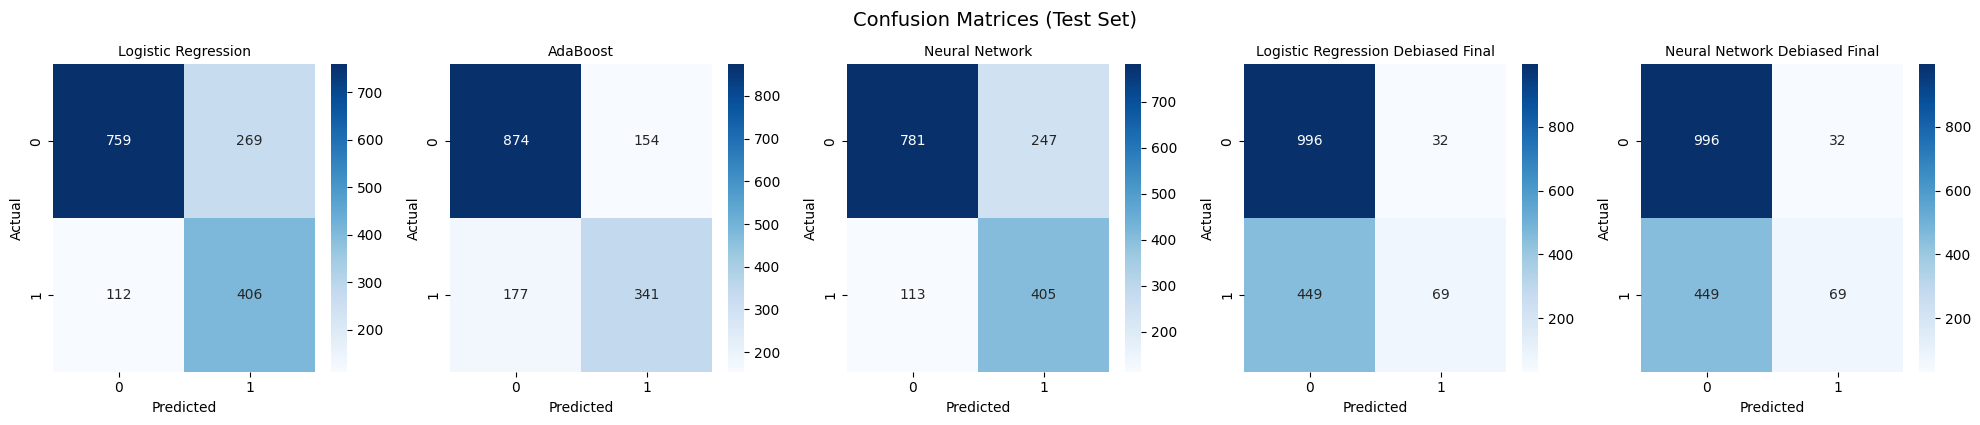

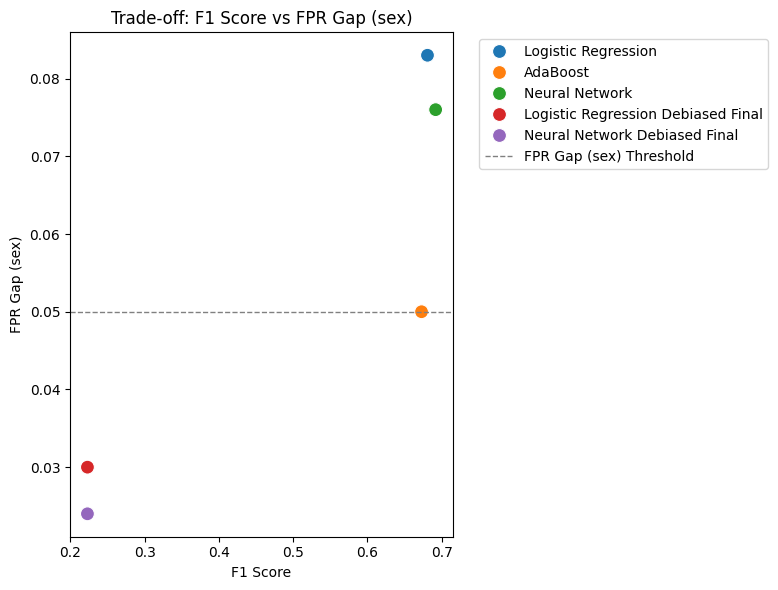

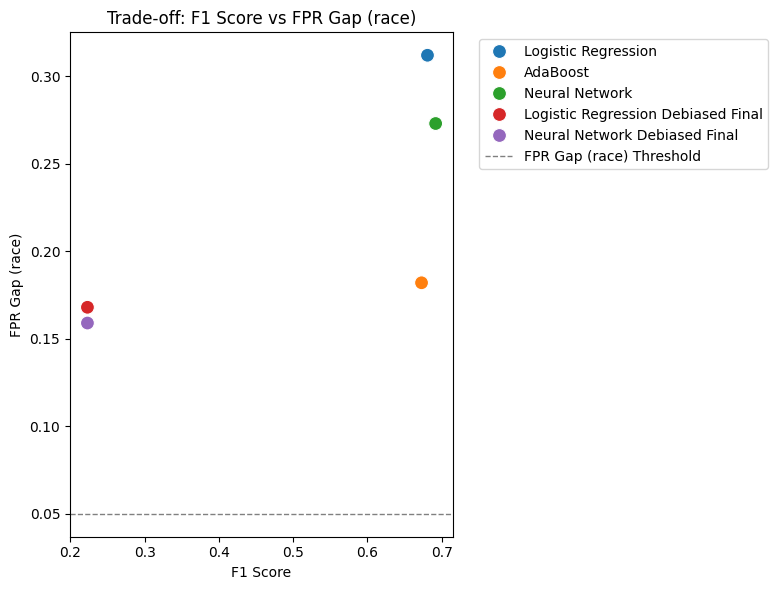

C:\Users\wastl\AppData\Local\Temp\ipykernel_25828\2760159101.py:46: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_eval, x="Model", y="Bias Amplification", palette="coolwarm")


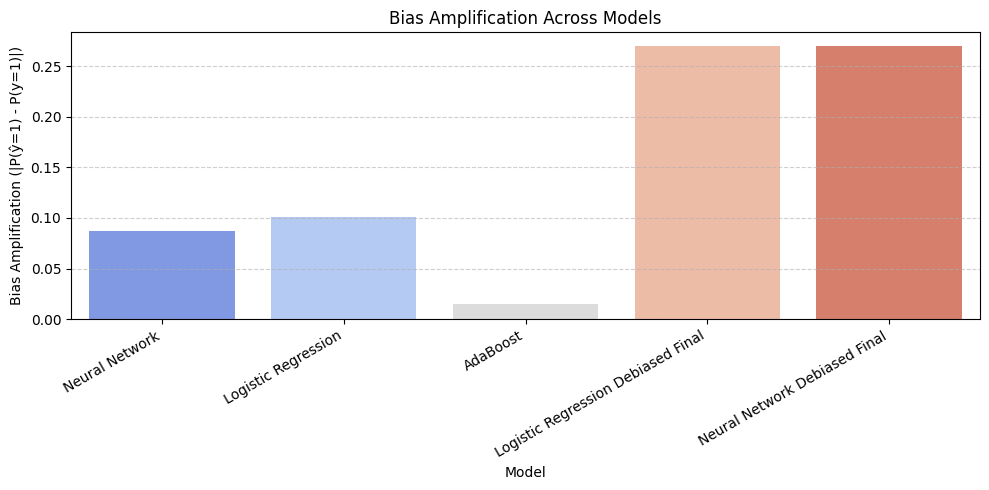

In [35]:
# Plot confusion matrices side-by-side and visualize trade-offs between performance and fairness

# Plot Confusion Matrices
fig, axes = plt.subplots(1, len(conf_matrices), figsize=(4 * len(conf_matrices), 4))
if len(conf_matrices) == 1:
    axes = [axes]

for ax, (model_name, cm) in zip(axes, conf_matrices.items()):
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=ax)
    ax.set_title(model_name, fontsize=10)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

plt.tight_layout()
plt.suptitle("Confusion Matrices (Test Set)", y=1.05, fontsize=14)
plt.savefig("../reports/03_evaluation/confusion_matrices_testset.png")
plt.show()

# Plot Trade-off between F1 Score and Fairness (FPR Gap)
df_tradeoff = pd.DataFrame(results)

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_tradeoff, x="F1 Score", y="FPR Gap (sex)", hue="Model", s=100)
plt.title("Trade-off: F1 Score vs FPR Gap (sex)")
plt.xlabel("F1 Score")
plt.ylabel("FPR Gap (sex)")
plt.axhline(0.05, color="gray", linestyle="--", linewidth=1, label="FPR Gap (sex) Threshold")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("../reports/03_evaluation/tradeoff_analysis_sex.png")
plt.show()

plt.figure(figsize=(8, 6))
sns.scatterplot(data=df_tradeoff, x="F1 Score", y="FPR Gap (race)", hue="Model", s=100)
plt.title("Trade-off: F1 Score vs FPR Gap (race)")
plt.xlabel("F1 Score")
plt.ylabel("FPR Gap (race)")
plt.axhline(0.05, color="gray", linestyle="--", linewidth=1, label="FPR Gap (race) Threshold")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig("../reports/03_evaluation/tradeoff_analysis_race.png")
plt.show()

# === Bias Amplification Bar Plot ===
plt.figure(figsize=(10, 5))
sns.barplot(data=df_eval, x="Model", y="Bias Amplification", palette="coolwarm")
plt.xticks(rotation=30, ha="right")
plt.ylabel("Bias Amplification (|P(ŷ=1) - P(y=1)|)")
plt.title("Bias Amplification Across Models")
plt.tight_layout()
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.savefig("../reports/03_evaluation/bias_amplification.png")
plt.show()

